In [3]:
import pymongo
from pymongo import MongoClient
import json
import string
import operator 
from collections import Counter
from collections import defaultdict
import sys
import os
import tweepy
import twitter
from tweepy import Stream
from tweepy.streaming import StreamListener
import time
from tweepy import OAuthHandler
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
import pandas
from prettytable import PrettyTable

In [4]:
#Establishing the database connection to MongoDb Database for example "twitter_db"
try:
    client = MongoClient('localhost', 27017)
    db = client['twitter_db']
    collection = db['twitter_collection']
except BaseException, e:
    print str(e)
    pass

In [5]:
# Find out how many tweets (documents) are in users collection, efficiently 
tweetcount = db.twitter_collection.find().count()
print "There are %d documents in users collection" % tweetcount 

There are 71403 documents in users collection


In [6]:
tweets_iterator = collection.find()
for tweet in tweets_iterator:
    try:
        tweet_text = ( tweet['text'])
        user_screen_name = tweet['user']['screen_name']
        user_name = tweet['user']['name']
        retweet_count = tweet['retweeted_status']['retweet_count']
        retweeted_name = tweet['retweeted_status']['user']['name']
        retweeted_screen_name = tweet['retweeted_status']['user']['screen_name']
    except:
        pass

In [7]:
tweets_iterator = collection.find()
retweets = [
            # Store out a tuple of these three values ...
            (status['retweeted_status']['retweet_count'], 
             status['retweeted_status']['user']['screen_name'],
             status['text']) 
            
            # ... for each status ...
            for status in tweets_iterator 
            
            # ... so long as the status meets this condition.
                if status.has_key('retweeted_status')
           ]

In [8]:
# Slice off the first 10 from the sorted results and display each item in the tuple

pt = PrettyTable(field_names=['Count', 'Screen Name', 'Text'])
[ pt.add_row(row) for row in sorted(retweets, reverse=True)[:10] ]
pt.max_width['Text'] = 50
pt.align= 'l'
print pt

+-------+-------------+----------------------------------------------------+
| Count | Screen Name | Text                                               |
+-------+-------------+----------------------------------------------------+
| 4985  | Panthers    | RT @Panthers: Don't test him!!                     |
|       |             |                                                    |
|       |             | Another interception for #LUUUUKE! #CARvsDAL       |
|       |             | https://t.co/E8AEn8Uc6N                            |
| 4984  | Panthers    | RT @Panthers: Don't test him!!                     |
|       |             |                                                    |
|       |             | Another interception for #LUUUUKE! #CARvsDAL       |
|       |             | https://t.co/E8AEn8Uc6N                            |
| 4983  | Panthers    | RT @Panthers: Don't test him!!                     |
|       |             |                                                    |

In [9]:
# Function to Pre-process the tweets
# @-mentions, emoticons, URLs and #hash-tags are now preserved as individual tokens
# We try to capture some emoticons, HTML tags, Twitter @usernames (@-mentions), 
# Twitter #hashtags, URLs, numbers, words with and without dashes and apostrophes, and finally “anything else”
import re

emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

In [10]:
#Function to pretty print the JSON file we have collected in the previous function call
#this function is just for testing purposes to see that the JSON data is loaded from the file
tweets_iterator = collection.find()
for tweet in tweets_iterator:
    try:
        tokens = preprocess(tweet['text'])
    except:
        pass

In [11]:
#"text":"RT @NFL: .@LukeKuechly Had a Day! #CARvsDAL https:\/\/t.co\/MngpsMwpfz"

punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ['rt', 'via']
terms_stop = [term for term in preprocess(tweet['text']) if term not in stop]
print terms_stop

[u'RT', u'@dallascowboys', u'@ninjafast22', u'see', u'#CARvsDAL', u'https://t.co/3MGEYRWqSI']


In [12]:
tweets_iterator = collection.find()
count_all = Counter()
count_all_hash = Counter()
count_all_terms = Counter()
for tweet in tweets_iterator:
    try: 
        # Create a list with all the terms
        terms_all = [term for term in preprocess(tweet['text']) if term not in stop]
        # Update the counter
        count_all.update(terms_all)
        # Count terms only once, equivalent to Document Frequency
        terms_single = set(terms_all)
        # Count hashtags only
        terms_hash = [term for term in preprocess(tweet['text']) if term.startswith('#')]
        count_all_hash.update(terms_hash)
        count_all.update(terms_hash)
        # Count terms only (no hashtags, no mentions)
        terms_only = [term for term in preprocess(tweet['text']) if term not in stop and not term.startswith(('#', '@'))] 
        count_all_terms.update(terms_only)
        count_all_terms.update(terms_only)
    except:
        pass

# Print the first 5 most frequent words
print(count_all.most_common(10))
print(count_all_hash.most_common(10))
print(count_all_terms.most_common(10))

[(u'#CARvsDAL', 132896), (u'RT', 54830), (u'@Panthers', 23874), (u'#Panthers', 16314), (u'@NFL', 16046), (u'\ud83d', 13341), (u'#LUUUUKE', 10386), (u'Romo', 8729), (u'@dallascowboys', 8240), (u'6', 7853)]
[(u'#CARvsDAL', 66448), (u'#Panthers', 8157), (u'#LUUUUKE', 5193), (u'#KeepPounding', 3033), (u'#Cowboys', 2901), (u'#Pick6', 1132), (u'#LUUUUUUKE', 1046), (u'#Picked', 1020), (u'#NFL', 748), (u'#TOUCHDOWN', 707)]
[(u'RT', 109660), (u'\ud83d', 26682), (u'Romo', 17458), (u'6', 15706), (u'Tony', 13614), (u'\u2026', 11710), (u'Newton', 11424), (u'Luke', 10644), (u'Dab', 9458), (u'30', 9436)]


In [13]:
def per_minute(SearchKeyword):
    dates_SearchKeyword = []
    # f is the file pointer to the JSON data set
    tweets_iterator = collection.find()
    for tweet in tweets_iterator:
        try:
            # let's focus on hashtags only at the moment
            terms_hash = [term for term in preprocess(tweet['text']) if term.startswith('#')]
            # track when the hashtag is mentioned
            if '#' + SearchKeyword in terms_hash:
                dates_SearchKeyword.append(tweet['created_at'])
        except:
            pass

    # a list of "1" to count the hashtags
    ones = [1]*len(dates_SearchKeyword)
    # the index of the series
    idx = pandas.DatetimeIndex(dates_SearchKeyword)
    # the actual series (at series of 1s for the moment)
    SearchKeyword = pandas.Series(ones, index=idx)

    # Resampling / bucketing
    per_minute_freq = SearchKeyword.resample('1Min', how='sum').fillna(0)
    return per_minute_freq

In [14]:
per_minute_CARvsDAL = per_minute('CARvsDAL')
per_minute_Cowboys = per_minute('Cowboys')
per_minute_Panthers = per_minute('Panthers')
per_minute_TOUCHDOWN = per_minute('TOUCHDOWN')

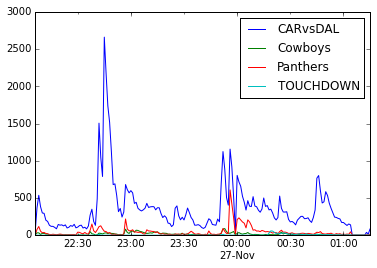

In [15]:
%matplotlib inline
# all the data together
match_data = dict(CARvsDAL=per_minute_CARvsDAL, Cowboys=per_minute_Cowboys, Panthers=per_minute_Panthers,
                  TOUCHDOWN=per_minute_TOUCHDOWN)
# we need a DataFrame, to accommodate multiple series
all_matches = pandas.DataFrame(data=match_data,
                               index=per_minute_CARvsDAL.index)
# Resampling as above
all_matches = all_matches.resample('1Min', how='sum').fillna(0)

columns_list = ['CARvsDAL','Cowboys','Panthers', 'TOUCHDOWN']
df = pandas.DataFrame(all_matches, columns=columns_list)
plt.figure()
df.plot()
plt.show()

In [16]:
com = defaultdict(lambda : defaultdict(int))
tweets_iterator = collection.find()
for tweet in tweets_iterator: 
    try:
        terms_only = [term for term in preprocess(tweet['text']) 
                  if term not in stop 
                  and not term.startswith(('#', '@'))]
    except:
        pass
    # Build co-occurrence matrix
    for i in range(len(terms_only)-1):            
        for j in range(i+1, len(terms_only)):
            w1, w2 = sorted([terms_only[i], terms_only[j]])                
            if w1 != w2:
                com[w1][w2] += 1

In [17]:
com_max = []
# For each term, look for the most common co-occurrent terms
for t1 in com:
    t1_max_terms = max(com[t1].items(), key=operator.itemgetter(1))[:10]
    for t2 in t1_max_terms:
        com_max.append(((t1, t2), com[t1][t2]))
# Get the most frequent co-occurrences
terms_max = sorted(com_max, key=operator.itemgetter(1), reverse=True)
print(terms_max[:10])

[((u'\ud83d', u'\udd25'), 53208), ((u'Dab', u'Newton'), 9340), ((u'RT', u'\ud83d'), 7890), ((u'6', u'RT'), 7345), ((u'Romo', u'Tony'), 5555), ((u'Newton', u'RT'), 5244), ((u'30', u'6'), 4721), ((u'Luke', u'RT'), 4534), ((u'Kuechly', u'Luke'), 4523), ((u'Another', u'RT'), 4308)]


In [24]:
search_word = "KFC" # pass a search term
count_search = Counter()
tweets_iterator = collection.find()
for tweet in tweets_iterator: 
    try:
        terms_only = [term for term in preprocess(tweet['text']) if term not in stop and not term.startswith(('#', '@'))]
        if search_word in terms_only:
            count_search.update(terms_only)
    except:
        pass
print("Co-occurrence for %s:" % search_word)
print(count_search.most_common(20))

Co-occurrence for KFC:
[]


In [19]:
#Plotting the most frequent words
word_freq = terms_max[:20]
labels, freq = zip(*word_freq)
print labels, freq

((u'\ud83d', u'\udd25'), (u'Dab', u'Newton'), (u'RT', u'\ud83d'), (u'6', u'RT'), (u'Romo', u'Tony'), (u'Newton', u'RT'), (u'30', u'6'), (u'Luke', u'RT'), (u'Kuechly', u'Luke'), (u'Another', u'RT'), (u'\ud83c', u'\ud83d'), (u"Don't", u'RT'), (u'interception', u'test'), (u'https://t.co/E8AEn8Uc6N', u'test'), (u'2', u'RT'), (u'Cam', u'RT'), (u'3', u'RT'), (u'dance', u'name'), (u'Who', u'wants'), (u'idea', u'wants')) (53208, 9340, 7890, 7345, 5555, 5244, 4721, 4534, 4523, 4308, 4094, 4088, 4075, 4068, 3667, 3519, 3407, 3277, 3274, 3273)


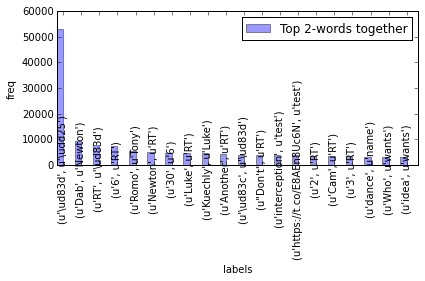

In [20]:
#Plot the top two words frequency as a bar chart
n_groups = 20

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(index, freq, bar_width,
                 alpha=opacity,
                 color='b',
                 error_kw=error_config,
                 label='Top 2-words together')

plt.xlabel('labels')
plt.ylabel('freq')
plt.xticks(index + bar_width, (labels))
ax.set_xticklabels( labels, rotation=90, va='center' ) ;
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
retweet_threshold = 3
tweets_iterator = collection.find()
for tweet in tweets_iterator:
    try: 
        # Create a list with all the terms
        popular_tweets = [ status for status in tweet if status['retweet_count'] > retweet_threshold ] 
    except:
        pass
    
for tweet in popular_tweets:
    print tweet['text'], tweet['retweet_count']

NameError: name 'popular_tweets' is not defined

In [22]:
retweet_threshold = 20
tweets_iterator = collection.find()
for tweet in tweets_iterator:
    # Create a list with all the terms
    if tweet['retweeted_status.retweet_count'] > retweet_threshold:
        print (tweet['text'], tweet['retweeted_status.retweet_count'])
    else:
        pass

KeyError: 'retweeted_status.retweet_count'

In [ ]:
retweet_threshold = 3
tweets_iterator = collection.find()
for tweetObj in tweets_iterator:
    keys =  tweetObj.keys()
    if 'retweet_count' in tweetObj and tweetObj['retweet_count'] >= retweet_threshold:
        print tweetObj['text'] 
        print tweetObj['retweet_count']
    else:
        pass